The following is our initial draft. We are looking to add more maps and analysis, and improve our ML models. However, we would like any comments or suggestions if any. 

# Part 1: Obtaining and Organizing Data

Using Socrata, we imported two datasets using the New York City Open Data Portal APIs. It included a dataset of property valuations in New York City, and another dataset listing the reassesment actions. App_tokens were used to adjust limits for valuation results and testing our code on smaller/larger datasets. 

In [1]:
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
client = Socrata("data.cityofnewyork.us", '9llM0ejMVTKfRxS1XlvL7gXjU')

#first one is the property valuation and assessment dataset, need to update the limit for this as we go forward (there are 9 million+ entries)
vresults = client.get("yjxr-fw8i", content_type='geojson', year = '2017/18', limit=10000000)

#second one is the assessment actions dataset
aresults = client.get("4nft-bihw", content_type='json', limit=100000) 

In [3]:
value_gdf = gpd.GeoDataFrame.from_features(vresults, crs='EPSG:4326')
actions_df = pd.DataFrame.from_records(aresults)

In order to combine the two datasets, a new column was made that combines the borough, block, and lot numbers (keeping it as a string).

In [4]:
value_gdf['BBB'] = value_gdf['boro'] + '-' + value_gdf['block'] + '-' + value_gdf['lot']
value_gdf['BBB']

actions_df['BBB'] = actions_df['borough_code'] + '-' + actions_df['block_number'] + '-' + actions_df['lot_number']
actions_df['BBB']

actions_df.set_index('BBB', inplace=True)
value_gdf.set_index('BBB', inplace=True)

We then conducted an inner join, so that each property reassessment had linked with its valuation.

In [7]:
inner_joined_gdf = value_gdf.join(actions_df, how='inner', rsuffix=('_actions'))

And then creating a new column that shows the percent reduction

In [8]:
#making them numeric first
inner_joined_gdf['granted_reduction_amount']=pd.to_numeric(inner_joined_gdf['granted_reduction_amount'])
inner_joined_gdf['avtot']=pd.to_numeric(inner_joined_gdf['avtot'])

#making the new column
inner_joined_gdf['reduction_scaled']=inner_joined_gdf['granted_reduction_amount']/inner_joined_gdf['avtot']

inner_joined_gdf.head()

,geometry,nta,avland,latitude,zip,stories,avtot,easement,valtype,exland,...,ltdepth,borough_code,block_number,lot_number,tax_year,owner_name,property_address,granted_reduction_amount,tax_class_code,reduction_scaled
BBB,,,,,,,,,,,,,,,,,,,,,
1-10-14,POINT (-74.01304 40.70331),Battery Park City-Lower Manhattan,7875000,40.703312,10004,30,38897100,None,AC-TR,0,...,161,1,10,14,2018,BROAD FINANCIAL CENTE,33 WHITEHALL STREET,1755500,4,0.045132
1-10-15,POINT (-74.01309 40.70352),Battery Park City-Lower Manhattan,406800,40.703517,10004,7,1720350,None,AC-TR,0,...,58,1,10,15,2018,MSA TWINS LTD,27 WHITEHALL STREET,92350,4,0.053681
1-10-33,POINT (-74.01264 40.70403),Battery Park City-Lower Manhattan,3690450,40.704025,10004,43,35656200,None,AC-TR,0,...,125,1,10,33,2018,AL STONE GROUND TENAN,8 STONE STREET,2158050,4,0.060524
1-100-1001,POINT (-74.00603 40.71154),Battery Park City-Lower Manhattan,65790,40.711541,10038,23,1183950,None,AC-TR,0,...,0,1,100,1001,2018,THE BRAUSER GROUP #1,150 NASSAU STREET,247400,4,0.208962
1-100-1201,POINT (-74.00540 40.71124),Battery Park City-Lower Manhattan,5841450,40.711245,10038,76,140023350,None,AC-TR,2759170,...,0,1,100,1201,2018,FC 8 SPRUCE STREET RE,8 SPRUCE STREET,3949350,2,0.028205


# Part 1.5: Obtaining and Organizing Census Data

We looked to analyze our datasets with connection to Census Tract information. We imported demographic information using Cenpy, and obtained it by County rather than the whole city due to mapping issues

In [9]:
from cenpy import products

def borough_census(borough):
    df=products.ACS(2017).from_county(borough+', NY', level='tract',
                                        variables=['B19019_001E', 'B01003_001E', '^B02001', 'B03003_003E', 'B25003_001E', 'B25003_002E', 'B25003_003E', 'B09001_001E', 'B01002_001E'])
    df.rename(columns={'B19019_001E':'median_HH_income', 'B01003_001E':'total_population', 'B02001_001E':'total_population_race','B02001_002E':'total_white'}, inplace=True)
    df.rename(columns={'B02001_003E':'total_black', 'B02001_004E':'total_americanindian', 'B02001_005E':'total_asian','B02001_006E':'total_hawaiian'}, inplace=True)
    df.rename(columns={'B02001_007E':'total_otherrace', 'B02001_008E':'total_twoplusraces', 'B03003_003E':'total_hisp_latino','B09001_001E':'pop_under18','B01002_001E':'median_age'}, inplace=True)
    df.drop(columns=['total_population_race', 'B02001_009E', 'B02001_010E'], inplace=True)
    df['pct_renter'] = df['B25003_003E']/df['B25003_001E']*100
    return df

In [11]:
#getting census data for each borough
manhattandf=borough_census('New York County')
brooklyndf=borough_census('King County')
bronxdf=borough_census('Bronx County')
queensdf=borough_census('Queens County')
statendf=borough_census('Richmond County')

boroughdfs=[manhattandf, brooklyndf, bronxdf, queensdf, statendf]
censusGdf=pd.concat(boroughdfs)

/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/shintuzd/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property

In [12]:
censusGdf.drop(columns=['B25003_001E', 'B25003_002E',
       'B25003_003E', 'NAME', 'state'], inplace=True)

sjoindf = censusGdf.sjoin(inner_joined_gdf.to_crs("EPSG:3857"),how='left')
sjoindf.head()

,GEOID,geometry,median_age,total_population,total_white,total_black,total_americanindian,total_asian,total_hawaiian,total_otherrace,...,ltdepth,borough_code,block_number,lot_number,tax_year,owner_name,property_address,granted_reduction_amount,tax_class_code,reduction_scaled
0,36061031900,"POLYGON ((-8240500.560 4968891.470, -8239842.1...",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36061006900,"POLYGON ((-8239939.840 4972655.360, -8239911.7...",35.2,2568.0,2037.0,53.0,0.0,293.0,0.0,57.0,...,0,1,601,1201,2018,43 CLARKSON HOLDING L,43 CLARKSON STREET,126550.0,4,0.461020
1,36061006900,"POLYGON ((-8239939.840 4972655.360, -8239911.7...",35.2,2568.0,2037.0,53.0,0.0,293.0,0.0,57.0,...,100,1,602,10,2018,"EQR - 600 WASHINGTON,",600 WASHINGTON STREET,2822750.0,2,0.138082
1,36061006900,"POLYGON ((-8239939.840 4972655.360, -8239911.7...",35.2,2568.0,2037.0,53.0,0.0,293.0,0.0,57.0,...,179,1,602,30,2018,GREENWICH MEWS TENANT,603 WASHINGTON STREET,624700.0,2,0.081473
1,36061006900,"POLYGON ((-8239939.840 4972655.360, -8239911.7...",35.2,2568.0,2037.0,53.0,0.0,293.0,0.0,57.0,...,188,1,602,36,2018,MORTON WEST LLC,611 WASHINGTON STREET,542200.0,4,0.050700


In [13]:
#making a new df with the total reduction amount granted per tract and joining it to census df
reductionpertract = sjoindf.groupby('tract')[['granted_reduction_amount']].sum()
reductionpertract.rename(columns={'granted_reduction_amount':'total_tract_reduction'}, inplace=True)
censusjoined = censusGdf.join(reductionpertract, on='tract')

In [14]:
#making a new df with the total number of reductions per tract
#adding another column for the total number of property reductions in a census tract
numberreductions = sjoindf.groupby('tract')[['tract']].count()
numberreductions.rename(columns={'tract':'number_reductions'}, inplace=True)
censusjoined = censusjoined.join(numberreductions, on='tract')
censusjoined.head()

,GEOID,geometry,median_age,total_population,total_white,total_black,total_americanindian,total_asian,total_hawaiian,total_otherrace,total_twoplusraces,total_hisp_latino,pop_under18,median_HH_income,county,tract,pct_renter,total_tract_reduction,number_reductions
0,36061031900,"POLYGON ((-8240500.560 4968891.470, -8239842.1...",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,061,031900,NaN,247760.0,7
1,36061006900,"POLYGON ((-8239939.840 4972655.360, -8239911.7...",35.2,2568.0,2037.0,53.0,0.0,293.0,0.0,57.0,128.0,161.0,341.0,198636.0,061,006900,60.673235,12720779.0,31
2,36061010300,"POLYGON ((-8237738.160 4975861.700, -8237700.9...",33.6,1674.0,1130.0,90.0,4.0,324.0,5.0,10.0,111.0,143.0,75.0,98901.0,061,010300,87.114846,10760925.0,27
3,36061008700,"POLYGON ((-8237672.930 4974484.150, -8237645.8...",35.8,6815.0,5493.0,85.0,0.0,579.0,0.0,478.0,180.0,1165.0,610.0,153350.0,061,008700,65.910868,25926957.0,59
4,36061011100,"POLYGON ((-8237493.260 4976308.140, -8237467.7...",33.4,5012.0,3111.0,367.0,0.0,1241.0,0.0,110.0,183.0,925.0,440.0,105887.0,061,011100,89.008942,34944588.0,24


# Part 2: Mapping

This map shows the percent reductions across NYC.

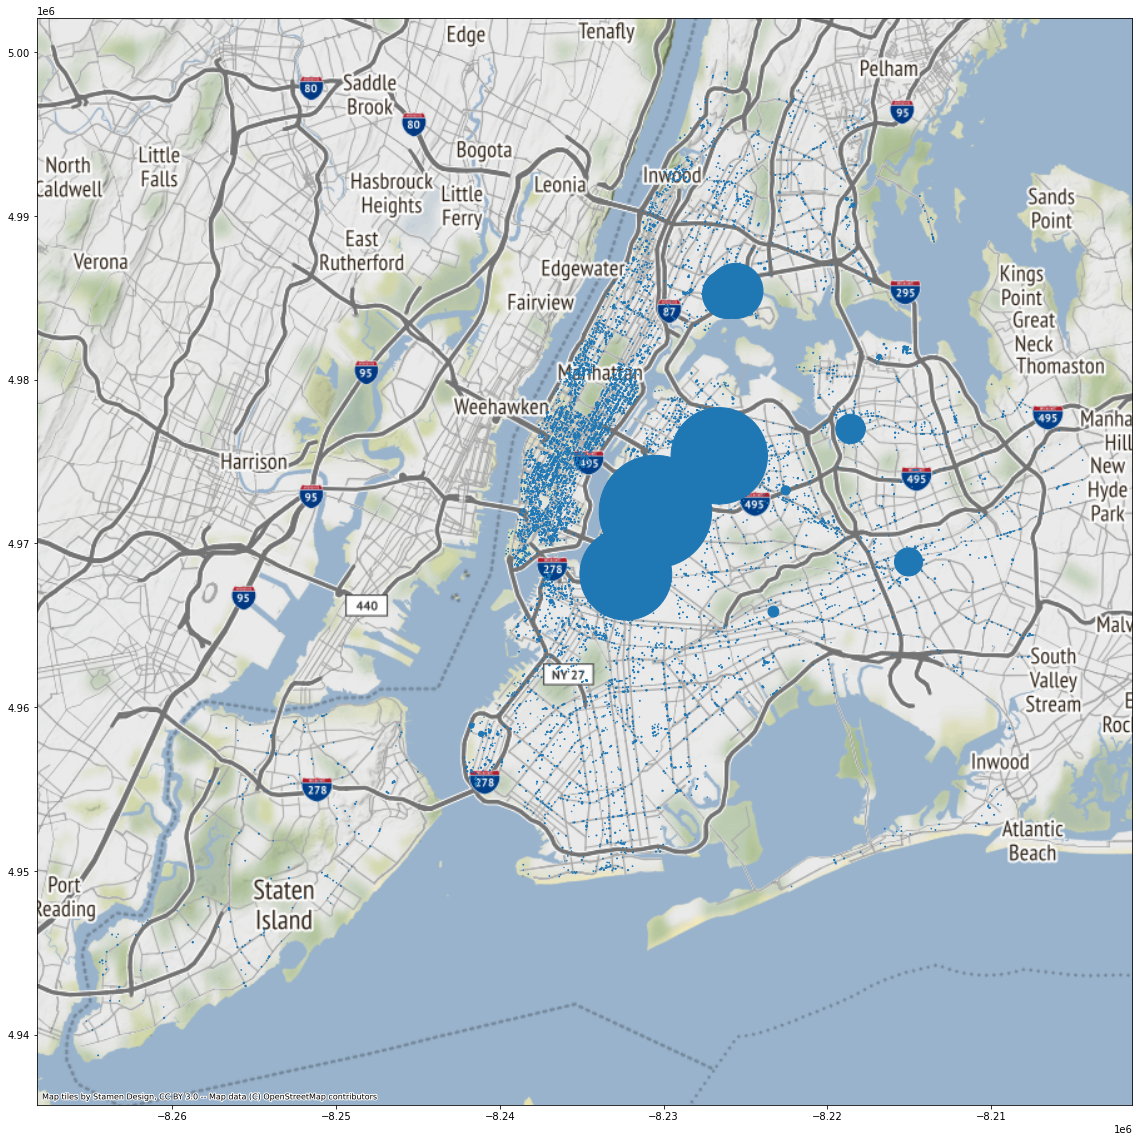

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
inner_joined_gdf.to_crs('EPSG:3857').plot(ax=ax, markersize=inner_joined_gdf['reduction_scaled']*5)
ctx.add_basemap(ax)

The two following maps use Census data to map the total value of reductions granted per Census tract, and the number of reductions given per Census tract.

Text(0.5, 1.0, 'Number of Reductions Granted Per Census Tract')

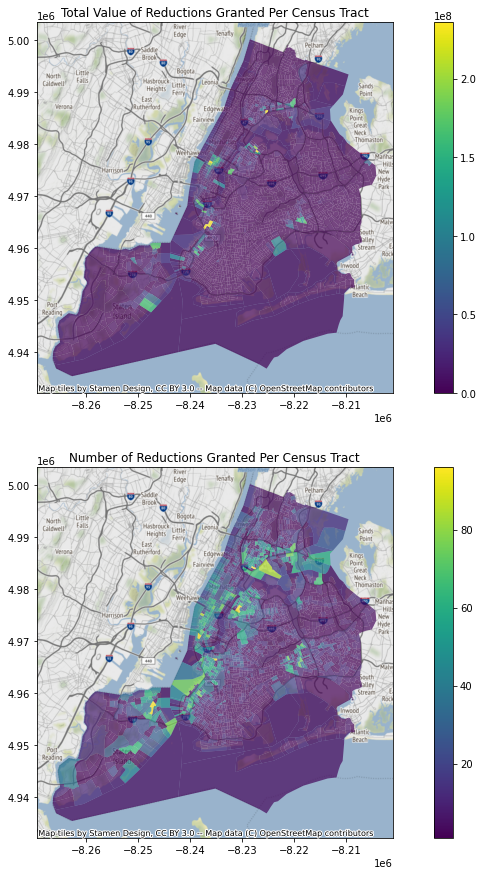

In [19]:
fig, ax = plt.subplots(2, figsize=(15,15))
ax1, ax2 = ax

censusjoined.plot(column='total_tract_reduction', ax=ax1, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax1)
ax1.set_title("Total Value of Reductions Granted Per Census Tract")

censusjoined.plot(column='number_reductions', ax=ax2, missing_kwds= dict(color = "grey"), alpha=.7, legend=True)
ctx.add_basemap(ax2)
ax2.set_title("Number of Reductions Granted Per Census Tract")

# Part 3: Machine Learning

### 1. Assessing the Total Value of Reductions in a Census Tract

We wanted to use Census information to see what variables are used to predict the total amount of reductions in a given Census tract.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['median_age', 'total_population', 'total_white',
       'total_black', 'total_americanindian', 'total_asian', 'total_hawaiian',
       'total_otherrace', 'total_twoplusraces', 'total_hisp_latino',
       'pop_under18', 'median_HH_income', 'county', 'pct_renter']

yvar = 'total_tract_reduction'

df_to_fit = censusjoined[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

1578 1578
526 526


In [21]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(len(X_test), len(y_pred))

526 526


In [22]:
import numpy as np
from sklearn import metrics

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))

Mean Absolute Error (MAE): 10759022.338783272
Mean Squared Error (MSE): 625103013572820.9
Root Mean Squared Error (RMSE): 25002060.186569043
Mean Absolute Percentage Error (MAPE): 2.892534422174553e+21
Explained Variance Score: 0.11993967550749374
Max Error: 225374594.92
Mean Squared Log Error: 30.13841399200122
Median Absolute Error: 3945304.61
R^2: 0.11947318250173844
Mean Poisson Deviance: 24581775.332783572


Text(0, 0.5, 'Mean decrease in impurity')

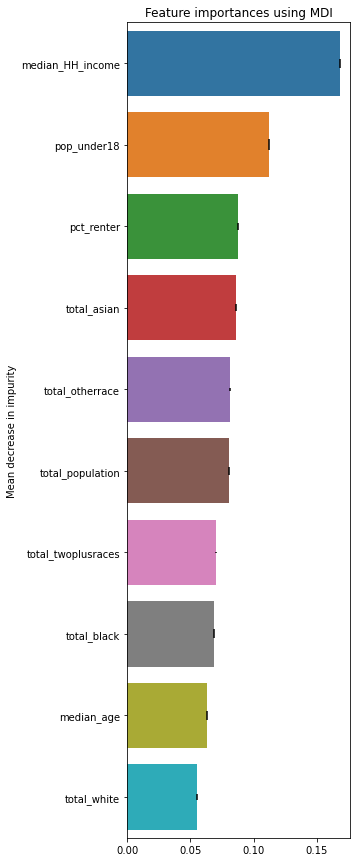

In [23]:
import seaborn as sns

importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# plot
fig, ax = plt.subplots(figsize=(4,15))
sns.barplot(x=forest_importances.values[:10], y=forest_importances.index[:10],yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### 2. Assessing the Total Number of Reductions in a Census Tract

We wanted to use Census information to see what variables are used to predict the number of reductions in a given Census tract.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

xvars = ['median_age', 'total_population', 'total_white',
       'total_black', 'total_americanindian', 'total_asian', 'total_hawaiian',
       'total_otherrace', 'total_twoplusraces', 'total_hisp_latino',
       'pop_under18', 'median_HH_income', 'county', 'pct_renter']

yvar = 'number_reductions'

df_to_fit = censusjoined[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

1578 1578
526 526


In [26]:
rf = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(len(X_test), len(y_pred))

526 526


In [27]:
import numpy as np
from sklearn import metrics

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))

Mean Absolute Error (MAE): 10.621482889733839
Mean Squared Error (MSE): 220.90830342205325
Root Mean Squared Error (RMSE): 14.862984337677721
Mean Absolute Percentage Error (MAPE): 2.833890464039115
Explained Variance Score: 0.2311194605652046
Max Error: 80.56
Mean Squared Log Error: 1.1425228377884444
Median Absolute Error: 8.31
R^2: 0.2220896293187371
Mean Poisson Deviance: 12.365239683399754


Text(0, 0.5, 'Mean decrease in impurity')

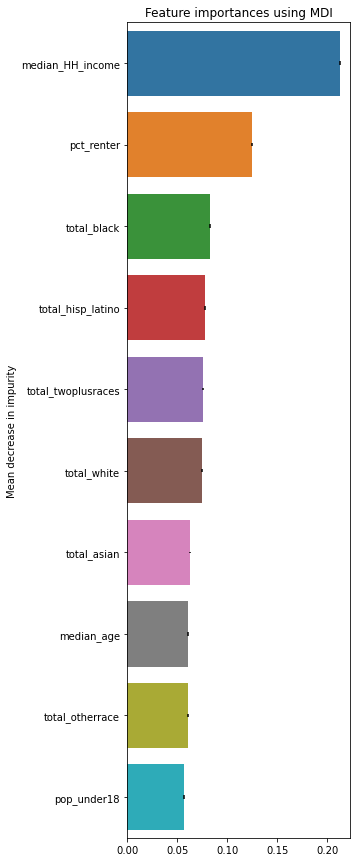

In [28]:
import seaborn as sns

importances = rf.feature_importances_

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)

# plot
fig, ax = plt.subplots(figsize=(4,15))
sns.barplot(x=forest_importances.values[:10], y=forest_importances.index[:10],yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

### 3. Assessing what contributes to a property getting a reassessment or not

To begin, I wanted to create a column that tells us whether a property from the assesment dataset got a reduction or not. So I created a join, while removing duplicates, that would left join the actions to the valuations.

In [29]:
actions_df.index.is_unique
value_gdf.index.is_unique

False

In [30]:
#creating two new datasets just without duplicates

print('Before dropping duplicates: {}'.format(len(actions_df)))
actions_nodupl = actions_df.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(actions_nodupl)))
actions_nodupl.index.is_unique

#same thing with the other
print('Before dropping duplicates: {}'.format(len(value_gdf)))
value_nodupl = value_gdf.groupby('BBB').first()
print('After dropping duplicates: {}'.format(len(value_nodupl)))
value_nodupl.index.is_unique

Before dropping duplicates: 12321
After dropping duplicates: 10062
Before dropping duplicates: 1110058
After dropping duplicates: 1105748


True

In [31]:
# the join

NewDf_for_ML = value_nodupl.join(actions_nodupl, how='left')
print('Number of valuations: {}'.format(len(NewDf_for_ML)))
print('Number of reductions: {}'.format(NewDf_for_ML['granted_reduction_amount'].count()))

#Almost all of the reductions got added so i think this is fine

Number of valuations: 1105748
Number of reductions: 10004


In [32]:
NewDf_for_ML.granted_reduction_amount.fillna(0,inplace=True)
NewDf_for_ML['granted_reduction_amount'] = NewDf_for_ML['granted_reduction_amount'].astype(float)
NewDf_for_ML['got_reduction'] = NewDf_for_ML['granted_reduction_amount'] > 0
NewDf_for_ML.head()

,geometry,nta,avland,latitude,zip,stories,avtot,easement,valtype,exland,...,ltdepth,borough_code,block_number,lot_number,tax_year,owner_name,property_address,granted_reduction_amount,tax_class_code,got_reduction
BBB,,,,,,,,,,,,,,,,,,,,,
1-1-10,POINT (-74.01287 40.69010),park-cemetery-etc-Manhattan,104445450,40.690096,10004,None,161206200,None,AC-TR,104445450,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False
1-1-101,POINT (-74.04534 40.68989),park-cemetery-etc-Manhattan,4225950,40.689887,10004,None,12873150,None,AC-TR,4225950,...,1046,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False
1-1-201,POINT (-74.03975 40.69883),park-cemetery-etc-Manhattan,14972400,40.698831,10004,None,111703950,None,AC-TR,14972400,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False
1-1-301,None,None,0,None,None,None,0,None,AC-TR,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False
1-1-401,None,None,0,None,None,None,0,None,AC-TR,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,False


In [33]:
from sklearn.model_selection import train_test_split

#we can put more interesting variables as we sort them out, but for now i used these 3

xvars = ['avtot','avland', 'stories', 'exland', 'extot', 'fullval']

yvar = 'got_reduction'

df_to_fit = NewDf_for_ML[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

790188 790188
263397 263397


In [34]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred

array([False, False, False, ..., False, False, False])

In [35]:
print(len(X_test), len(y_pred))

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
confusion_matrix

263397 263397
[[260703    338]
 [  2212    144]]


<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

Text(0, 0.5, 'Mean decrease in impurity')

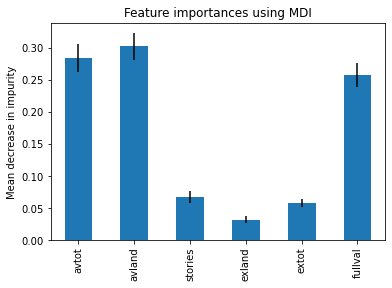

In [36]:
import numpy as np
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=X_train.columns)

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")